## Chapter 8 Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
excel_file_obj = pd.ExcelFile("../raw_data/SwordForecasting.xlsm")
raw_data = pd.read_excel(excel_file_obj, "Timeseries")
raw_data = raw_data.loc[0:35, :]

In [4]:
raw_data.tail()

,t,Demand
31,32,208.0
32,33,216.0
33,34,218.0
34,35,264.0
35,36,304.0


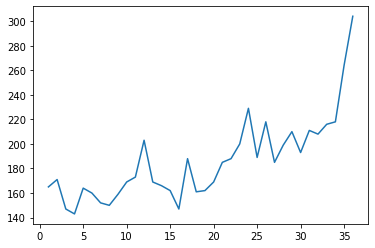

In [14]:
plt.plot(raw_data["t"], raw_data["Demand"])

### Exponential Smoothing - most recent observations weighted more than older observations

Weighting done through smoothing constants

Method 1 - Simple Exponential Smoothing

Two copmonents: a level (or mean) and some error around that level

Demand at time t = level + random error around the level at time t

One way to estimate level - could just take average of past several months

Or, more likely you want to give estimates of more recent data

level_0 = average of first years's demand (t <= 12)

then use level_0 to forecast t_1

in this case level_0 = 163
t_1 = 165, so delta = 2

You should then update the level to account for this

level_1 = level_0 + some percentage * (demand_1 - level_0)

level_2 = level_1 + some percentage * (demand_2 - level_1)


the percentage (usually denoted alpha) is the smoothing constant between 0 and 1

If you set alpha equal to 1 you account for all error which means level of current period is
demand of current period

If you set alpha to 0, no error correction on first estimate

whatever your last day of data is that's the level you use for future data, since it's the best one
we have for future data

In [17]:
level_0 = raw_data.loc[raw_data["t"] <= 12, "Demand"].mean()
level_0

163.0

In [18]:
alpha = 0.5

In [100]:
ses = raw_data.copy()
ses["level_estimate"] = None
ses["one_step_forecast"] = None
ses["forecast_error"] = None

first_row = ses["t"] == 1
ses.loc[first_row, "one_step_forecast"] = level_0
ses.loc[first_row, "forecast_error"] = ses.loc[first_row, "Demand"] - ses.loc[first_row, "one_step_forecast"]
ses.loc[first_row, "level_estimate"] = level_0 + alpha * ses.loc[first_row, "forecast_error"]

for i in range(1, ses.shape[0]):
    ith_row = ses.index == i
    prev_level_estimate = ses.at[i - 1, "level_estimate"]
    ses.loc[ith_row, "one_step_forecast"] = prev_level_estimate
    ses.loc[ith_row, "forecast_error"] = ses.at[i, "Demand"] - ses.at[i, "one_step_forecast"]
    ses.loc[ith_row, "level_estimate"] = prev_level_estimate + alpha * ses.at[i, "forecast_error"]




ses.loc[:, "forecast_error"] = ses.loc[:, "forecast_error"] ** 2
ses.tail(10)

,t,Demand,level_estimate,one_step_forecast,forecast_error
26,27,185.0,196.873,208.745,563.826
27,28,199.0,197.936,196.873,4.52622
28,29,210.0,203.968,197.936,145.534
29,30,193.0,198.484,203.968,120.3
30,31,211.0,204.742,198.484,156.649
31,32,208.0,206.371,204.742,10.6144
32,33,216.0,211.186,206.371,92.7173
33,34,218.0,214.593,211.186,46.4373
34,35,264.0,239.296,214.593,2441.08
35,36,304.0,271.648,239.296,4186.56


### To continue Forecasting you would use level_36 = 271.648 which is why the plots below you see that they are straight lines

## We want to examine the performance of this alpha

## Get Standard Deviation of SSE which is sqrt (SEE / (n  - 1)) since you lose one degree of freedom because of the model parameter you divide by n - 1 but look into this in more detail, he also calls this standard error when I think it's standard deviation

He says standard error is an estimate of the standard deviation when really we are using going after a sample standard deviation here? but lok back at this


In [102]:
np.sqrt(ses["forecast_error"].sum() / 35)

20.93995459784777

What this tell us is that 68% of forecast errors will be +/- forecast error, In the book he minimizes this, but this is really just picking an alpha that minimize the error associated with this simple forecasting model

### You want to pick optimal alpha
If alpha = 0 use previous level basically 
if you set it to 1, it will essentially just be set equal to demand of that period, as higher alpha more weight on more recent data, otherwise will be closer to older data

# Plot Comparisons

Going to compare my alpha=0.5 with standard statsmodels packages (both with hardcoded alpha=0.5) and then look to minimize error by letting it find the alpha

In [65]:
from statsmodels.tsa.api import SimpleExpSmoothing

Optimal Alpha 0.7329591836449602


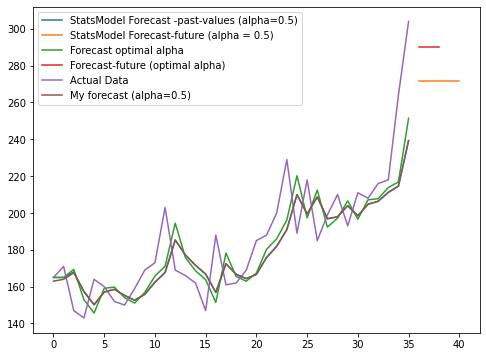

In [107]:
plt.figure(num=None, figsize=(8, 6))

# Fit using 0.5 non-optimized forecasted values past and future
fit1 = SimpleExpSmoothing(ses["Demand"]).fit(smoothing_level=0.5,optimized=False)
cast1 = fit1.forecast(5).rename(r'$\alpha=0.5$')
plt.plot(fit1.fittedvalues, label="StatsModel Forecast -past-values (alpha=0.5)")
plt.plot(cast1, label="StatsModel Forecast-future (alpha = 0.5)")

fit2 = SimpleExpSmoothing(ses["Demand"]).fit()
cast2 = fit2.forecast(3).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
print("Optimal Alpha", fit2.model.params['smoothing_level'])
plt.plot(fit2.fittedvalues, label="Forecast optimal alpha")
plt.plot(cast2, label="Forecast-future (optimal alpha)")


plt.plot(ses["Demand"], label="Actual Data")
plt.plot(ses["one_step_forecast"], label="My forecast (alpha=0.5)")

plt.legend(loc="best")

### Getting more sophisticated

Seems like there is a linear trend in the data, so we are going to fit a simple regression to test the null hypothesis that time is correlated with data at (alpha=5 percent level), note this is different alpha

In [108]:
import statsmodels.api as sm

In [110]:
demand = ses.loc[:, ["t", "Demand"]]
demand["intercept"] = 1

In [115]:
demand.tail()

,t,Demand,intercept
31,32,208.0,1
32,33,216.0,1
33,34,218.0,1
34,35,264.0,1
35,36,304.0,1


In [119]:
y = demand["Demand"].values
x = demand.loc[:, ["intercept", "t"]].to_numpy(dtype=np.int)

In [123]:
model = sm.OLS(y, x)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     55.69
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           1.17e-08
Time:                        20:02:24   Log-Likelihood:                -160.00
No. Observations:                  36   AIC:                             324.0
Df Residuals:                      34   BIC:                             327.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        139.0635      7.218     19.267      0.000     124.395     153.732
x1             2.5386      0.340      7.463      0.000       1.847       3.230
==============================================================================
Omnibus:                       17.157   Durbin-Watson:                   0.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.761
Skew:                           1.380   Prob(JB):                     1.88e-05
Kurtosis:                       5.625   Cond. No.                         43.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## This confirms that time has is correlated with demand and thus there is positive linear trend

## Need to use Holt's Trend-Corrected Exponential Smoothing

Demand at tie t = level + t * trend + random error around level at time t

so the t * trend is the new thing

Starting inputs:
level_0 and trend_0 can fit a simple line through data and intercept can be level_0 and slope can be trend_0


New Equation for the Level

level_t = level_(t-1) + trend_(t-1) + alpha * (demand_t - (level_(t-1) + trend_(t-1))

very similiar before just factoring in trend. alpha still a measure of how much to weight recent vs past data

trend_t = trend_(t-1) + gamma * alpha * (demand_t - (level_(t-1) + trend_(t-1))

Making sense of this is words very similiar to before. you are figuring out how to shift your trend from previous trend, well you take a portion of your error * alpha, and then multiply it by gamma since the trend is not reponsible for all of the error

Initial values will be plot fist 18 months of data and get scatter

Intercept:  155.88235294117644 Slope:  0.8369453044375649


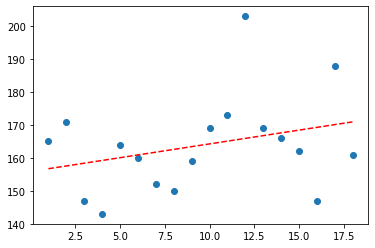

In [5]:
holt_df = raw_data.copy()
holt_df.loc[:, "t"] = holt_df.loc[:, "t"].astype(int)
first_18 = holt_df["t"] <= 18
x = holt_df.loc[first_18, "t"].values
y = holt_df.loc[first_18, "Demand"].values
plt.scatter(x, y)
z = np.polyfit(x, y, 1)
print("Intercept: ", z[1], "Slope: ", z[0])
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.show()

In [39]:
z

array([  0.8369453 , 155.88235294])

In [6]:
level_0_h = round(z[1], 2)
trend_0_h = round(z[0], 2)
alpha_holt = 0.5
gamma_holt = 0.5

In [7]:
trend_0_h

0.84

Do similiar to before where you fill in one row at a time, definitelya  cleaner way to do this but affecting math

In [19]:
holt_df = raw_data.copy()

holt_df["level_estimate"] = None
holt_df["trend_estimate"] = None
holt_df["one_step_forecast"] = None
holt_df["forecast_error"] = None

first_row = holt_df["t"] == 1
holt_df.loc[first_row, "one_step_forecast"] = level_0_h + trend_0_h
holt_df.loc[first_row, "forecast_error"] = holt_df.loc[first_row, "Demand"] - holt_df.loc[first_row, "one_step_forecast"]
holt_df.loc[first_row, "level_estimate"] = level_0_h + trend_0_h + alpha_holt * holt_df.loc[first_row, "forecast_error"]
holt_df.loc[first_row, "trend_estimate"] = trend_0_h + gamma_holt * alpha_holt * holt_df.loc[first_row, "forecast_error"]


for i in range(1, holt_df.shape[0]):
    ith_row = holt_df.index == i
    prev_level_estimate = holt_df.at[i - 1, "level_estimate"]
    prev_trend_estimate = holt_df.at[i - 1, "trend_estimate"]

    holt_df.loc[ith_row, "one_step_forecast"] = prev_level_estimate + prev_trend_estimate
    holt_df.loc[ith_row, "forecast_error"] = holt_df.at[i, "Demand"] - holt_df.at[i, "one_step_forecast"]
    
    holt_df.loc[ith_row, "level_estimate"] = holt_df.at[i, "one_step_forecast"] + alpha_holt * holt_df.at[i, "forecast_error"]
    holt_df.loc[ith_row, "trend_estimate"] = prev_trend_estimate + gamma_holt * alpha_holt * holt_df.at[i, "forecast_error"]



#holt_df.loc[:, "forecast_error"] = holt_df.loc[:, "forecast_error"] ** 2
holt_df.tail(10)

,t,Demand,level_estimate,trend_estimate,one_step_forecast,forecast_error
26,27,185.0,203.345,-4.01278,221.691,-36.6906
27,28,199.0,199.166,-4.0959,199.333,-0.3325
28,29,210.0,202.535,-0.36349,195.07,14.9297
29,30,193.0,197.586,-2.65641,202.172,-9.17168
30,31,211.0,202.965,1.36123,194.929,16.0706
31,32,208.0,206.163,2.27974,204.326,3.67405
32,33,216.0,212.221,4.16907,208.443,7.55728
33,34,218.0,217.195,4.57146,216.39,1.60958
34,35,264.0,242.883,15.1298,221.767,42.2333
35,36,304.0,281.007,26.6265,258.013,45.9869


### Key is that for this to forecast out from month 36, in SES (above) you would just take final level

Now you take

Forecast in month n where n > 36

Forecast = level_36 + trend_estimate_36 * (n - 36)

Example 37
Forecast for 37 = 281 + 26.63 * 1 = 307
Forecast for 38 = 281 + 26.63 * 2 = 334

Sothis way your future predictiosn aren't constant

### Let's now plot

Optimal Params {'smoothing_level': 0.6608133734013051, 'smoothing_slope': 0.0, 'smoothing_seasonal': nan, 'damping_slope': nan, 'initial_level': 158.99582311081133, 'initial_slope': 3.549304255811156, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


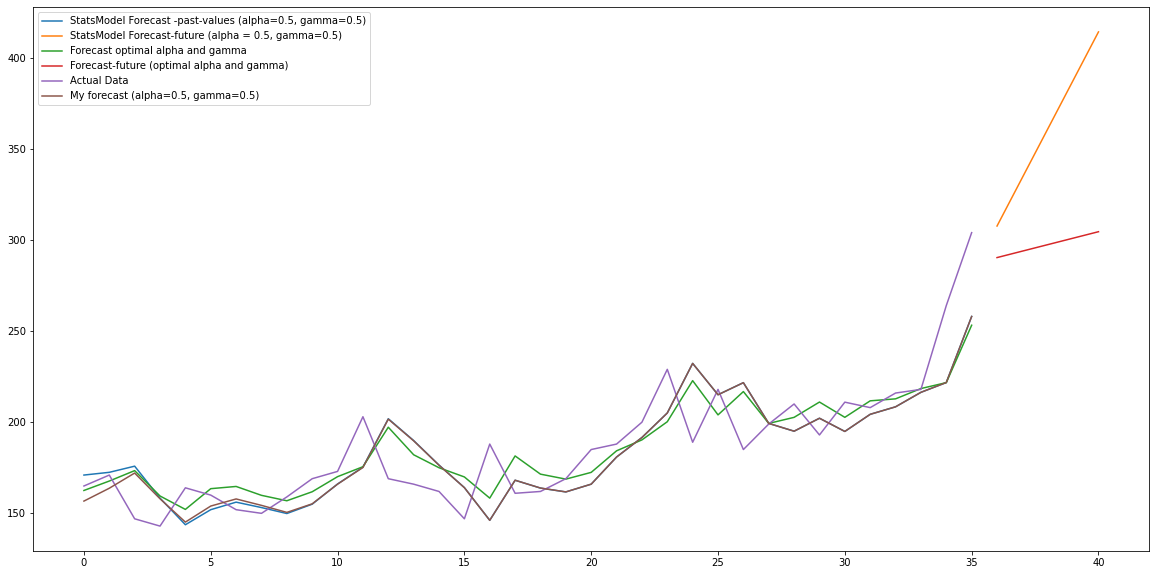

In [20]:
from statsmodels.tsa.api import Holt
plt.figure(num=None, figsize=(20, 10))


fit1 = Holt(holt_df["Demand"]).fit(smoothing_level=0.5,smoothing_slope=0.5, optimized=False)
cast1 = fit1.forecast(5).rename(r'$\alpha=0.5$')
plt.plot(fit1.fittedvalues, label="StatsModel Forecast -past-values (alpha=0.5, gamma=0.5)")
plt.plot(cast1, label="StatsModel Forecast-future (alpha = 0.5, gamma=0.5)")

fit2 = Holt(holt_df["Demand"]).fit()
cast2 = fit2.forecast(5)
plt.plot(fit2.fittedvalues, label="Forecast optimal alpha and gamma")
plt.plot(cast2, label="Forecast-future (optimal alpha and gamma)")
print("Optimal Params", fit2.model.params)
#print("Optimal Gamma", fit2.model.params['smoothing_slope'])


plt.plot(holt_df["Demand"], label="Actual Data")
plt.plot(holt_df["one_step_forecast"], label="My forecast (alpha=0.5, gamma=0.5)")

plt.legend(loc="best")
plt.show()

### Again you see blue and red diverse initially but overall my forecast matches the stats-model almost exact and you see linear slope predction as opposed to flat since before the forecast had the form y = c and now it's y = mx + b so has linear slope

You also see those initial values track the optimized version reasonably well but teh forecast of optimal looks a bit more realistic

I get a bit different from teh book, this takes into account initial slope so even though gamma was set to 0 , I think it's taking into account initial slope but even in book he got 0.05 so a very weak trend component

## Looking at Auto Correlations

ONe way to check if you have a good mdoel for forecasting is checking one step ahad errors If errors are random, then it's good if there's a pattern (you miss big on december every team) then likely auto correlation. Good way to check it

In [21]:
holt_df.head(10)

,t,Demand,level_estimate,trend_estimate,one_step_forecast,forecast_error
0,1,165.0,160.86,2.91,156.72,8.28
1,2,171.0,167.385,4.7175,163.77,7.23
2,3,147.0,159.551,-1.55813,172.102,-25.1025
3,4,143.0,150.497,-5.30641,157.993,-14.9931
4,5,164.0,154.595,-0.603945,145.19,18.8098
5,6,160.0,156.996,0.898271,153.991,6.00887
6,7,152.0,154.947,-0.575188,157.894,-5.89384
7,8,150.0,152.186,-1.66812,154.372,-4.37173
8,9,159.0,154.759,0.452443,150.518,8.48226
9,10,169.0,162.106,3.89961,155.211,13.7887


In [22]:
avg_error = holt_df.loc[:, "forecast_error"].mean()
holt_df.loc[:, "error_dev"] = holt_df.loc[:, "forecast_error"] - avg_error

In [23]:
holt_df.head()

,t,Demand,level_estimate,trend_estimate,one_step_forecast,forecast_error,error_dev
0,1,165.0,160.86,2.91,156.72,8.28,5.41483
1,2,171.0,167.385,4.7175,163.77,7.23,4.36483
2,3,147.0,159.551,-1.55813,172.102,-25.1025,-27.9677
3,4,143.0,150.497,-5.30641,157.993,-14.9931,-17.8583
4,5,164.0,154.595,-0.603945,145.19,18.8098,15.9447


In [50]:
# Generate lagged Effects
for lag in range(1, 13):
    holt_df.loc[:, "lag_{i}_error_dev".format(i=lag)] = holt_df.shift(lag)["error_dev"]
holt_df = holt_df.fillna(0)

In [51]:
holt_df.head()

,t,Demand,level_estimate,trend_estimate,one_step_forecast,forecast_error,error_dev,lag_1_error_dev,lag_2_error_dev,lag_3_error_dev,lag_4_error_dev,lag_5_error_dev,lag_6_error_dev,lag_7_error_dev,lag_8_error_dev,lag_9_error_dev,lag_10_error_dev,lag_11_error_dev,lag_12_error_dev
0,1,165.0,160.860000,2.910000,156.720000,8.280000,5.414832,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,171.0,167.385000,4.717500,163.770000,7.230000,4.364832,5.414832,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,147.0,159.551250,-1.558125,172.102500,-25.102500,-27.967668,4.364832,5.414832,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,143.0,150.496562,-5.306406,157.993125,-14.993125,-17.858293,-27.967668,4.364832,5.414832,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,164.0,154.595078,-0.603945,145.190156,18.809844,15.944676,-17.858293,-27.967668,4.364832,5.414832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### We then take the dot product of these two arrays, as similiar vectors in space will have a higher dot product, and orthagonal ones will be 0, so it's a good benchmark. Author claims threshold for auto correlation is  2 / sqrt(# of data points)

### You also don't want a really negative value either because it shows they are opposites, so ideally want it close to 0 shows that there is not a pattern to the data, ie no correlation when you lag shift

To normalize it you divide by Sum of Squared Deviations in original array

In [52]:
total_squared_devs = (holt_df["error_dev"] ** 2).sum()

In [53]:
cut_off = 2 / np.sqrt(36)
cut_off

0.3333333333333333

In [54]:
vals = {}
for i in range(1, 13):
    dot_product = np.dot(holt_df["error_dev"], holt_df["lag_{i}_error_dev".format(i=i)])
    vals[i] = dot_product / total_squared_devs

In [55]:
vals

{1: 0.0555008569408327,
 2: 0.033304096847814574,
 3: -0.06362949430616256,
 4: -0.1755730429631098,
 5: 0.09407048752230662,
 6: -0.12970640022816093,
 7: 0.09087070453711402,
 8: -0.3425692869423283,
 9: -0.0807933171409322,
 10: -0.13258065579121261,
 11: 0.08788863025757385,
 12: 0.3947613924116855}

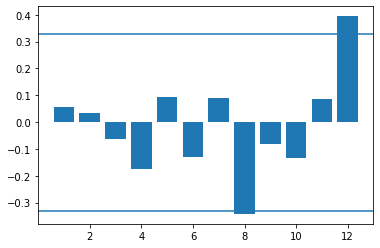

In [61]:
plt.bar(vals.keys(), vals.values())
plt.axhline(0.33)
plt.axhline(-0.33)

## We see here that shifting by 12 we see lots of correlation which makes sense this is likely telling us there is certain seasonality which we factor in to improve our forecast

### Next Step of Sophistication - Multiplicative Holt-Winters Exponential Smoothing

Accounts for level, trend, and need to adjust demand up or down due to seasonal fluctuations

But don't want to just add for seasonality, want it to be multiplicative. Think about it it's more of in dec holidays says will be boosted 120% as opposed to add some fixed number

Called triple exponential smoothing - three params
alpha
gamma
delta - seasonal adjustment factor

Going to go a bit more complicated, we don't go back just one period, you got back one period for trend and level but one "seasonal period" for seasonlity. So you back 12 months in this example. For seasonality, makes sense to go back to July 2018 if trying to forecast July 2019


New update rules

level_t = level_t-1 + trend_t-1 + alpha * (demand_t - (level_t-1 + trendt-1) * seasonality_last_relevant) / seasonality_last_relevant

Errors gets seasonal adjustment by dividing by it. Makes sense if seasonality is really strong you want to account for that when calculating your error (but need to drill deeper on this

trend_t = trend_t-1 + gamma * alpha * (demand_t - (level_t-1 + trend_t-1) * seasonality_last_relevant) / seasonality_last_relevant

seasonality_t = seasonality_last_relevant + delta * (1 - alpha) * (demand_t - (level_t-1 + trend_t-1) * seasonality * last_relevant) / (level_t-1 + trend_t- 1)


Basically updating the the seasonal factor from 12 months ago, but you are going to factor in delta as to what portion of error can be attributed to seasonality.  

Notice also you are not dividng by seasonal in this case, in this case you want to divide by the forecast so that you can get it in terms of a multiplier (dividing two forecasts) so you get a seasonal multiplier

In this case, you need to get an initial value of level, trend, and 12 seasonal factors

Here is how he does it
1. Smooth out historical data using a moving average
2. Compare smooth versions to original to estimate seasonality
3. Using initial seasonal estimates, deseaonalize historical data
4. Estimate level and trend using a trendline on the deseasonalized data

## At some point may implement this but for now going to use the python library to get optimal, alpha, gamma and delta, and the library probably uses a similiar method of initialization

In [79]:
holt_autocorr = raw_data.copy()
#holt_autocorr = holt_autocorr.set_index("t")

In [80]:
holt_autocorr.head()

,t,Demand
0,1,165.0
1,2,171.0
2,3,147.0
3,4,143.0
4,5,164.0


In [114]:
# Need to convert t into a datetime 
holt_autocorr["year"] =  np.where(holt_autocorr["t"] <= 12, 2007, np.where(holt_autocorr["t"].between(12, 24),  2008, 2009))
holt_autocorr["month"] = holt_autocorr["t"] % 12
holt_autocorr.loc[holt_autocorr["month"] == 0, "month"] = 12
holt_autocorr["day"] = 1
holt_autocorr["dt"] = pd.to_datetime(holt_autocorr[['year', 'month', 'day']])
holt_auto_final = holt_autocorr.loc[:, ["Demand", "dt"]].set_index("dt")

In [116]:
holt_auto_final.head()

,Demand
dt,
2007-01-01,165.0
2007-02-01,171.0
2007-03-01,147.0
2007-04-01,143.0
2007-05-01,164.0


Optimal Params {'smoothing_level': 0.21057514181175885, 'smoothing_slope': 0.21057513820917476, 'smoothing_seasonal': 0.10524758926216665, 'damping_slope': nan, 'initial_level': 174.33289910797714, 'initial_slope': 1.1804986257360914, 'initial_seasons': array([0.92845417, 0.98109897, 0.85713328, 0.8442969 , 0.95202043,
       0.86033065, 0.87351924, 0.86208068, 0.90245507, 0.91330553,
       1.01135212, 1.15304801]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


/home/blake/book_follow_alongs/data_smart/data_smart_venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/blake/book_follow_alongs/data_smart/data_smart_venv/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


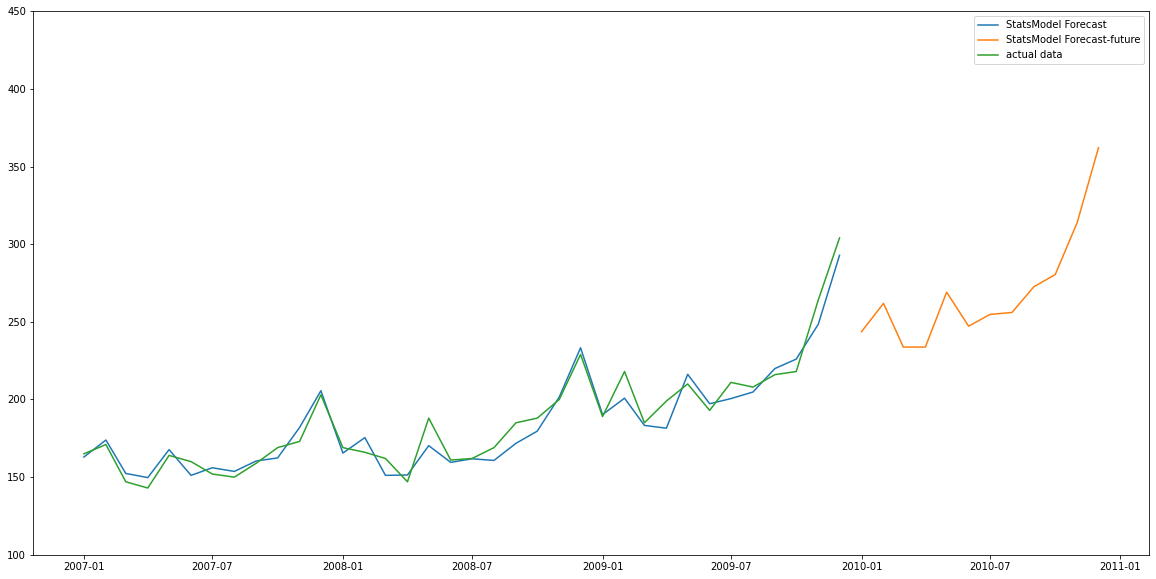

In [125]:
plt.figure(num=None, figsize=(20, 10))
from statsmodels.tsa.api import ExponentialSmoothing

fit1 = ExponentialSmoothing(holt_auto_final, seasonal_periods=12, trend='add', seasonal='mul').fit()
cast1 = fit1.forecast(12)
plt.plot(fit1.fittedvalues, label="StatsModel Forecast")
plt.plot(cast1, label="StatsModel Forecast-future")
plt.plot(holt_auto_final, label="actual data")
print("Optimal Params", fit1.model.params)
plt.ylim(100, 450)

plt.legend(loc="best")

### So you can see initial values start out a little differently but it fits optimal values for alpha, lamba and gamma and tells you the parameters there and we can see this forecast is much more sophisticated but it accounts for positive linear trend growth but also takes into account some months will be higher than others due to seasonality

In [130]:
holt_auto_final.head()

,Demand
dt,
2007-01-01,165.0
2007-02-01,171.0
2007-03-01,147.0
2007-04-01,143.0
2007-05-01,164.0


s_t = seasonality, level = l_t, trend = b_t

In [129]:
# Getting inside scoop of model
holt_winters = pd.DataFrame(np.c_[holt_auto_final, fit1.level, fit1.slope, fit1.season, fit1.fittedvalues],
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=holt_auto_final.index)
holt_winters.append(fit1.forecast(8).rename(r'$\hat{y}_t$').to_frame(), sort=True)

,$\hat{y}_t$,$b_t$,$l_t$,$s_t$,$y_t$
2007-01-01,162.956147,1.278111,175.976948,0.929680,165.0
2007-02-01,173.904755,1.146827,176.631605,0.979374,171.0
2007-03-01,152.379811,0.868514,176.456754,0.853948,147.0
2007-04-01,149.715174,0.515838,175.650444,0.840311,143.0
2007-05-01,167.713899,0.342857,175.344814,0.949802,164.0
2007-06-01,151.149487,0.799017,177.853929,0.865633,160.0
2007-07-01,156.056786,0.593085,177.674996,0.871129,152.0
2007-08-01,153.681468,0.403726,177.368831,0.859907,150.0
2007-09-01,160.431746,0.333377,177.438479,0.901607,159.0
2007-10-01,162.360020,0.655755,179.302795,0.917237,169.0


In [124]:
cast1

2010-01-01    243.653544
2010-02-01    261.894278
2010-03-01    233.728698
2010-04-01    233.769819
2010-05-01    269.091744
2010-06-01    247.207091
2010-07-01    254.738356
2010-08-01    256.025261
2010-09-01    272.616274
2010-10-01    280.410811
2010-11-01    313.900717
2010-12-01    362.089388
Freq: MS, dtype: float64

In [126]:
#TODO: Functionize the above code when calculating autocorrelation value, at some point need to check that
# the new forecast is <=  0.33 or (>= -0.33) but for now going to move on

## Prediction Intervals

I'm going to use the python functions at this point, but the important lesson of what he does.  He gets the standard dev of forecast errors. Takes the Sum of Squared Errors and then divide by sqrt(36 -3 ) where 36 is n and now you have 3 parameters so you have lost 3 degrees of freedom.



To - do research why this works, he kind of glosses over it
I think this explains it:
https://en.wikipedia.org/wiki/Mean_squared_error

where the sample variance of mean squared error is sum of x - x-bar / divide by n -1 but in this case we add more because of model parameters


Then you assume unbiased forecast of mean 0 and standard dev. He then basically plucks random errors from normal distribution from the the bell curve N(0, 10.37). Then using the forecast and error, he gets actual demand. Do that 100 times, and you get 100 different scenarios for actual demand.

Then what you can do is for each column (t=1 to t=36) you can do percentile(values, 0.975) and percentile(values, 0.025) to get the values that construct the 95 % confidence interval that you can then go plot

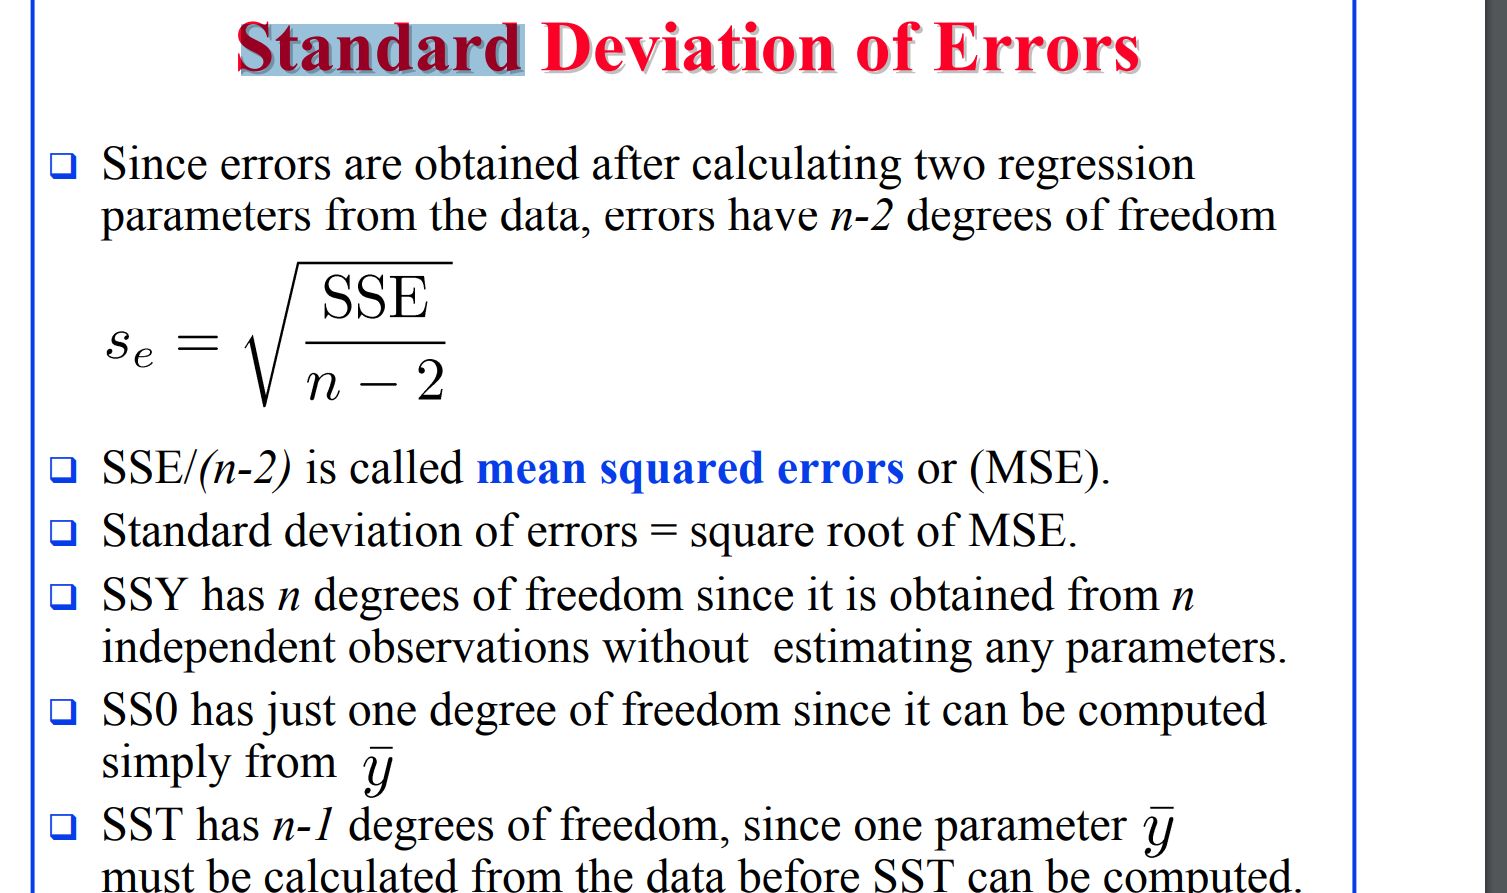

We want to get the standard deviation in order to calculate normal distribution and sample from it to construct the interval

Source: https://www.cse.wustl.edu/~jain/iucee/ftp/k_14slr.pdf

### Constructing the prediction intervals

In [152]:
y_yhat = holt_auto_final.join(pd.DataFrame(fit1.fittedvalues))
final_df = pd.concat([y_yhat, cast1])
final_df.columns = ["yhat", "y"]
final_df["error"] = (final_df["y"] - final_df["yhat"]) ** 2

In [153]:
final_df.head()

,yhat,y,error
2007-01-01,162.956147,165.0,4.177337
2007-02-01,173.904755,171.0,8.437600
2007-03-01,152.379811,147.0,28.942368
2007-04-01,149.715174,143.0,45.093556
2007-05-01,167.713899,164.0,13.793049


In [163]:
SSE = final_df.loc[:, "error"].sum()
std_dev = np.sqrt(SSE / (36  - 3)) # n - number of degrees of freedom

In [164]:
std_dev

8.632799881084818

In [160]:
forecast_rows = final_df.loc[final_df["y"].isnull(), :]

In [162]:
forecast_rows.head(12)

,yhat,y,error
2010-01-01,243.653544,NaN,NaN
2010-02-01,261.894278,NaN,NaN
2010-03-01,233.728698,NaN,NaN
2010-04-01,233.769819,NaN,NaN
2010-05-01,269.091744,NaN,NaN
2010-06-01,247.207091,NaN,NaN
2010-07-01,254.738356,NaN,NaN
2010-08-01,256.025261,NaN,NaN
2010-09-01,272.616274,NaN,NaN
2010-10-01,280.410811,NaN,NaN


In [166]:
# Now going to sample error and then fill it in
from scipy.stats import norm
import random
n_loops = 100
n_forecasts = 12
forecasts = np.ndarray(shape=(n_loops, n_forecasts))
for i in range(n_loops):
    for j in range(n_forecasts):
        error = norm.ppf(random.random(), loc=0, scale=std_dev)
        forecasts[i, j] = forecast_rows.iloc[j, 0] + error      

In [167]:
forecasts

array([[245.87872941, 257.9176752 , 237.47849526, ..., 273.6714944 ,
        301.2928905 , 354.13611212],
       [247.30522125, 258.44328399, 242.27530258, ..., 277.68540454,
        309.82720668, 367.49313658],
       [245.01342985, 258.71785892, 232.09277261, ..., 281.51357187,
        314.38935194, 371.12906613],
       ...,
       [258.06294923, 247.41147427, 236.77060754, ..., 278.87943582,
        310.06977954, 350.35161862],
       [244.56250378, 254.48357651, 231.96676329, ..., 292.56464255,
        307.54993722, 341.75298701],
       [228.83419579, 261.18508173, 217.9740884 , ..., 286.8751489 ,
        315.45920493, 353.88374851]])

In [171]:
# Next, I need to get the 95 % confidence interval vals
list_of_lower_and_upper_bounds = []
for j in range(n_forecasts):
    forecasts_for_month_j = forecasts[:, j]
    lower_val = np.percentile(forecasts_for_month_j, 2.5)
    upper_val = np.percentile(forecasts_for_month_j, 97.5)
    list_of_lower_and_upper_bounds.append((lower_val, upper_val))

In [172]:
list_of_lower_and_upper_bounds

[(227.5460923173867, 263.5057356147716),
 (246.58612643114273, 277.7657585821572),
 (216.68018758244887, 250.61060808554953),
 (216.30255490295502, 250.2979537408155),
 (250.9224658923124, 284.863299045064),
 (229.93168517025816, 263.0374991104359),
 (239.7351162003849, 270.13002624841477),
 (238.74875433990135, 269.2590568221781),
 (254.8452229038905, 289.0854528505697),
 (264.2832980376658, 300.5010561648372),
 (301.8537544972123, 330.26064164821827),
 (344.87551892965524, 375.7809223659509)]

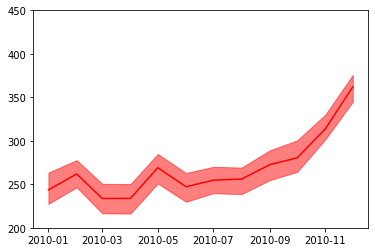

In [176]:
fig, ax = plt.subplots()
x = forecast_rows.index
y = forecast_rows["yhat"]

lower_vals = [lower for lower, _ in list_of_lower_and_upper_bounds]
upper_vals = [upper for _, upper in list_of_lower_and_upper_bounds]
ax.fill_between(x, lower_vals, upper_vals, color='red', alpha=0.5)

ax.plot(x, y, color='red') # Plot the original signal
plt.ylim(200, 450)

plt.show()

## This allows me to simulate what demand will look and have some confidence for where it's going to fall - just relies on getting error distribution from the data, to combine that with forecast and then try to get what demand will actually be